In [166]:
import pandas as pd
import pingouin as pg
import lightgbm as lgb
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

csv_path = 'outlier_removed.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)
# 데이터 확인
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,0,1,1,3.0,4,2,1,1,6.641182,low-mid
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,1,1,1,4.0,4,4,1,1,4.941642,low-mid
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,1,1,1,4.0,4,4,1,1,4.875197,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,0,1,1,4.0,4,4,1,1,4.290459,mid
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,1,1,1,4.0,4,4,1,1,4.077537,mid
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,0,1,1,4.0,4,4,0,1,5.703782,mid


In [167]:
# 수치형 변수만 선택
numeric_df = df.select_dtypes(include='number')

# 상관계수 계산
corr_matrix = numeric_df.corr(method='pearson')

c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\HY\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


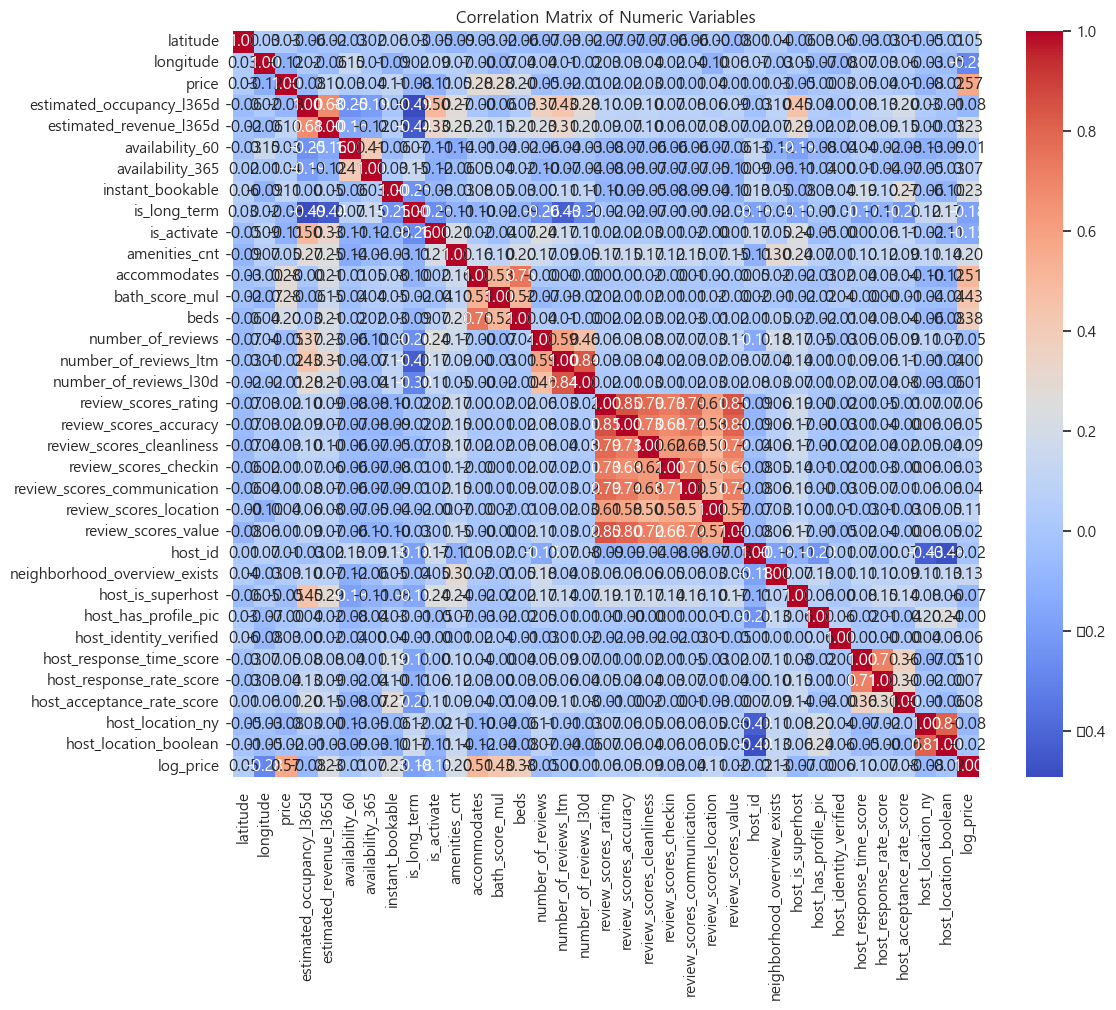

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

In [169]:
import time
import json
import requests
import geopandas as gpd
from shapely.geometry import Point
# ─────────────────────────────────────────────────────────────────────────────
# 0) 원본 df, poi_tags, 그리고 bbox 계산
  # latitude, longitude 칼럼이 있어야 함
poi_tags = {
    'transport': {
        'amenity': ['bus_station','taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}
pad = 0.01
minx, maxx = df.longitude.min()-pad, df.longitude.max()+pad
miny, maxy = df.latitude.min()-pad, df.latitude.max()+pad
# ─────────────────────────────────────────────────────────────────────────────
# 1) 한 번에 bbox 내 모든 POI 내려받기 (Overpass bbox 쿼리)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"
# build filters for bbox query
filters = ""
for grp in poi_tags.values():
    for key, vals in grp.items():
        for v in vals:
            filters += f'node["{key}"="{v}"]({miny},{minx},{maxy},{maxx});\n'
# full query
query = f"""
[out:json][timeout:180];
(
{filters}
);
out body;
"""
resp = requests.post(OVERPASS_URL, data={'data': query}, timeout=(5,300))
resp.raise_for_status()
data = resp.json().get('elements', [])
# ─────────────────────────────────────────────────────────────────────────────
# 2) GeoDataFrame 생성
pois = pd.DataFrame([
    {
      'lon': el['lon'],
      'lat': el['lat'],
      **el.get('tags',{})
    }
    for el in data
    if el['type']=='node' and 'lon' in el
])
gdf_pois = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(pois.lon, pois.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)
# 원본 좌표도 GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)
sindex = gdf_pois.sindex
# ─────────────────────────────────────────────────────────────────────────────
# 3) 그룹별 카운트 함수
def count_group(pt, grp_map, radius=1000):
    buf = pt.buffer(radius)
    candidates = gdf_pois.iloc[list(sindex.intersection(buf.bounds))]
    cnt = 0
    for key, vals in grp_map.items():
        cnt += candidates[candidates[key].isin(vals)].shape[0]
    return cnt
# 4) 각 포인트별 count, df에 붙이기
for grp, tags in poi_tags.items():
    df[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000)
        for pt in gdf_pts.geometry
    ]
# 5) 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count']].head())

       transport_count  infrastructure_count  tourism_count
id                                                         
36121                7                    77              1
36647                3                    79              4
38663               11                   109              2
38833                4                    34              2
39282                7                   117              1


In [170]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type,transport_count,infrastructure_count,tourism_count
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,4.0,4,4,1,1,5.303305,mid,7,77,1
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,4.0,4,4,1,1,4.418841,upper-mid,3,79,4
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,3.0,4,2,1,1,6.641182,low-mid,11,109,2
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,4.0,4,4,1,1,4.941642,low-mid,4,34,2
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,4.0,4,4,1,1,4.875197,mid,7,117,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,4.0,4,4,1,1,4.290459,mid,4,58,4
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,4.0,4,4,1,1,4.077537,mid,4,27,1
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,4.0,4,4,0,1,5.703782,mid,8,276,6


In [171]:
from sklearn.decomposition import PCA
poi_cols = ['transport_count','infrastructure_count','tourism_count']
pca = PCA(n_components=1)
# PCA fit → PC1 점수 생성
df['poi_pca1'] = pca.fit_transform(df[poi_cols].fillna(0))
# 설명 분산 비율 확인 (얼마나 데이터의 변동성을 담았는지)
print("Explained variance ratio (PC1):", pca.explained_variance_ratio_[0])
#poi_pca1 <0 poi 희박 지역, poi_pca1 > 0 poi 밀집지역

Explained variance ratio (PC1): 0.9981724847022044


In [172]:
# 위치데이터 카운트 변수들 정규성/등분산성

from scipy.stats import shapiro, levene

Location = ['transport_count', 'infrastructure_count', 'tourism_count', 'poi_pca1']
TARGET = 'host_is_superhost'

for col in Location:
    print(f"\n 변수: {col}")

    # 정규성 검정 (랜덤 샘플링)
    group1 = df[df[TARGET]==1][col].dropna()
    group0 = df[df[TARGET]==0][col].dropna()
    
    n1 = min(5000, len(group1))
    n0 = min(5000, len(group0))

    stat1, p1 = shapiro(group1.sample(n1, random_state=42))
    stat0, p0 = shapiro(group0.sample(n0, random_state=42))

    print(f"정규성 p값 (group1): {p1:.4f}, (group0): {p0:.4f}")

    # 등분산성 검정
    stat, p = levene(group1, group0)
    print(f"등분산성 p값: {p:.4f}")



 변수: transport_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: infrastructure_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: tourism_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: poi_pca1
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000


In [173]:
# 장소 변수별 비모수 검정 
from scipy.stats import mannwhitneyu

for col in Location:
    group1 = df[df[TARGET]==1][col].dropna()
    group0 = df[df[TARGET]==0][col].dropna()

    stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
    print(f"{col} - Mann-Whitney U p값: {p:.4f}")

transport_count - Mann-Whitney U p값: 0.0000
infrastructure_count - Mann-Whitney U p값: 0.0000
tourism_count - Mann-Whitney U p값: 0.0000
poi_pca1 - Mann-Whitney U p값: 0.0000


In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# X, y 분리
X = df[Location]
y = df[TARGET].astype(int)

# 학습용/테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
logit = LogisticRegression(max_iter=1000, class_weight='balanced')
logit.fit(X_train, y_train)

# 예측
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

# 평가
print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_prob), 4))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.78      0.38      0.51      3235
           1       0.30      0.72      0.43      1227

    accuracy                           0.47      4462
   macro avg       0.54      0.55      0.47      4462
weighted avg       0.65      0.47      0.49      4462

AUC: 0.5597


In [175]:
from sklearn.ensemble import RandomForestClassifier

# X, y 분리
X = df[Location]
y = df[TARGET].astype(int)

rf = RandomForestClassifier(
    n_estimators=2000,  # 더 많은 트리
    max_depth=30,      # 최대 깊이 제한
    min_samples_split=15,  # 노드 분할 최소 샘플 수
    min_samples_leaf=10,    # 리프 노드 최소 샘플 수
    random_state=42,
    class_weight='balanced')

# 학습용/테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# 평가
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_prob), 4))



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      3235
           1       0.37      0.51      0.43      1227

    accuracy                           0.63      4462
   macro avg       0.58      0.59      0.58      4462
weighted avg       0.67      0.63      0.64      4462

AUC: 0.6499


In [176]:
# 변수 중요도
importances_rf = pd.Series(rf.feature_importances_, index=Location)
print("\n=== Random Forest 변수 중요도 ===")
print(importances_rf.sort_values(ascending=False))


=== Random Forest 변수 중요도 ===
poi_pca1                0.425864
infrastructure_count    0.259179
transport_count         0.166048
tourism_count           0.148909
dtype: float64


In [177]:
#Location 중앙값, 평균차

# 중앙값 테이블
Location_median = pd.DataFrame({
    'variable': Location,
    'superhost_median': [df[df['host_is_superhost'] == 1][col].median() for col in Location],
    'non_superhost_median': [df[df['host_is_superhost'] == 0][col].median() for col in Location]})

# 평균값 테이블 
Location_median_avg = pd.DataFrame({
    'variable': Location,
    'superhost_avg': [df[df['host_is_superhost'] == 1][col].mean().round(2) for col in Location],
    'non_superhost_avg': [df[df['host_is_superhost'] == 0][col].mean().round(2) for col in Location]})
 
# 평균 + 중앙값 테이블 합치기
Location_merged = pd.merge(Location_median_avg,Location_median,on='variable')

# 차이 컬럼 추가
Location_merged['mean_diff'] = (Location_merged['superhost_avg'] - Location_merged['non_superhost_avg']).round(2)
Location_merged['median_diff'] = (Location_merged['superhost_median'] - Location_merged['non_superhost_median']).round(2)

# 차이 기준 정렬
Location_merged.sort_values('mean_diff', ascending=False)

,variable,superhost_avg,non_superhost_avg,superhost_median,non_superhost_median,mean_diff,median_diff
2,tourism_count,3.49,4.62,2.000000,3.000000,-1.13,-1.00
0,transport_count,5.15,6.37,4.000000,4.000000,-1.22,0.00
1,infrastructure_count,100.54,127.65,63.000000,82.000000,-27.11,-19.00
3,poi_pca1,-19.69,7.47,-57.262691,-38.392555,-27.16,-18.87


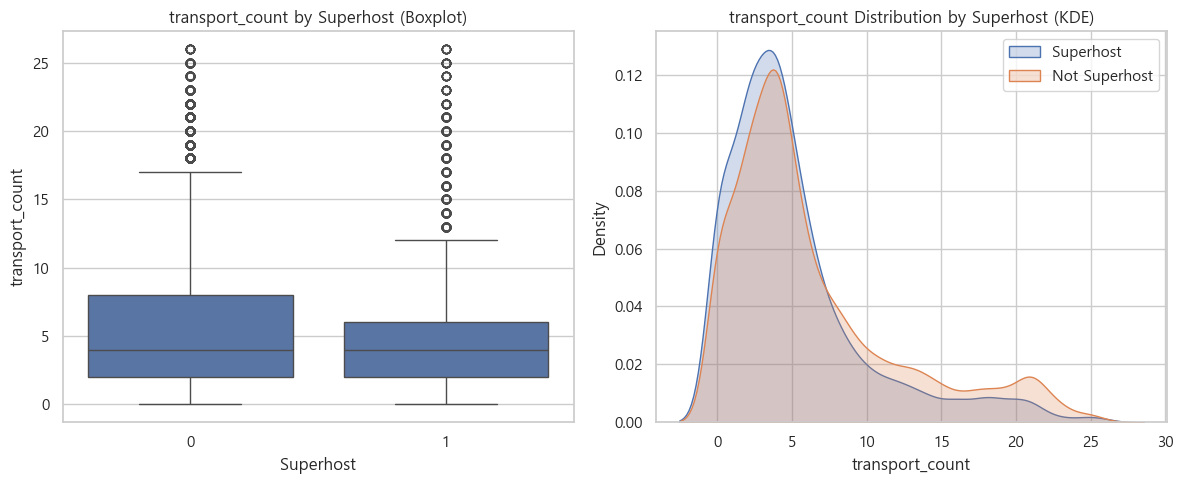

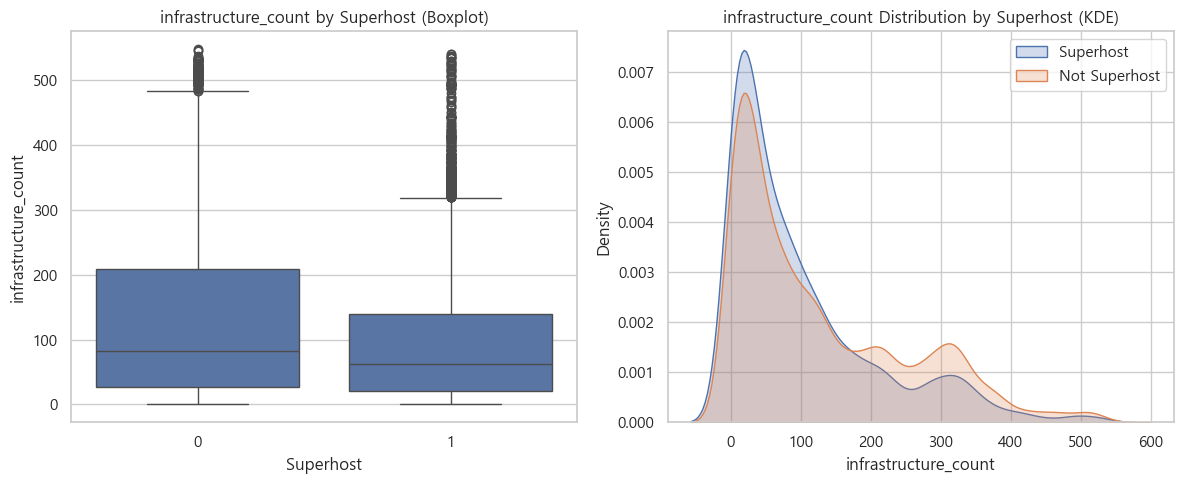

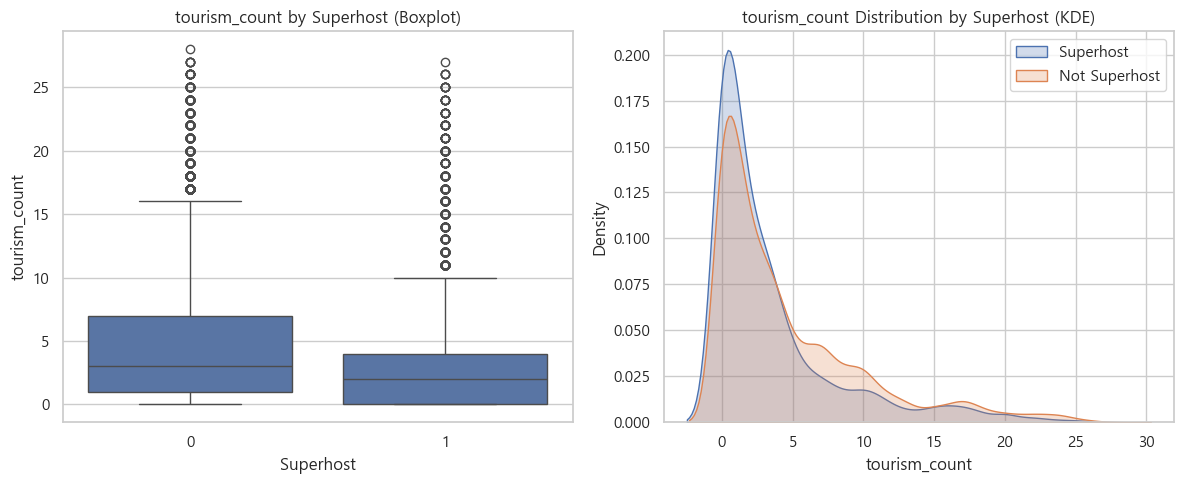

C:\Users\HY\AppData\Local\Temp\ipykernel_4660\2240141732.py:24: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\HY\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


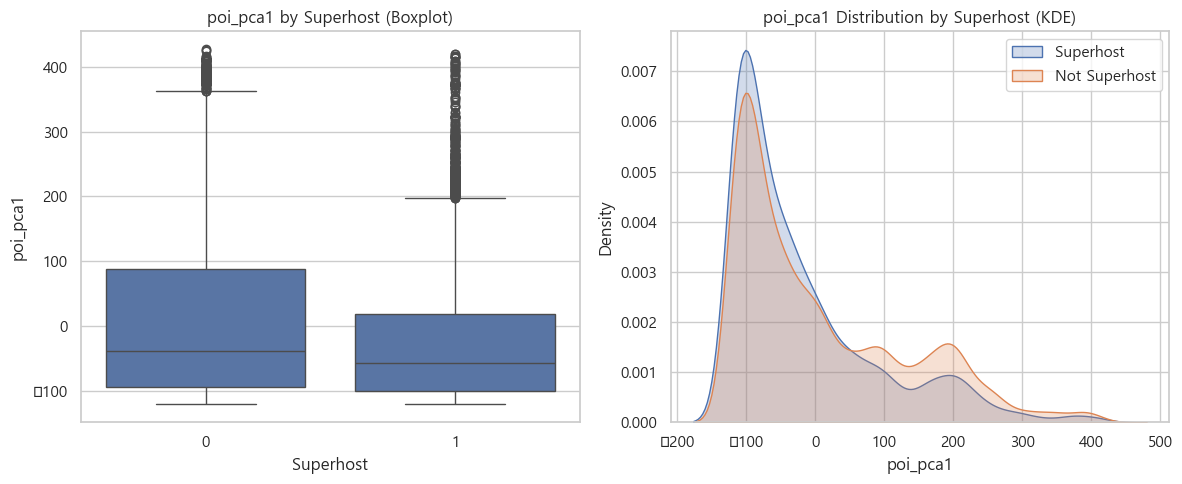

In [178]:
# 박스플롯 & 커널밀도 히스토그램 (각 변수별 슈퍼호스트 유무 분포)
import seaborn as sns
import matplotlib.pyplot as plt
location_vars = ['transport_count', 'infrastructure_count', 'tourism_count','poi_pca1']

for var in location_vars:
    plt.figure(figsize=(12, 5))

    # 박스플롯
    plt.subplot(1, 2, 1)
    sns.boxplot(x='host_is_superhost', y=var, data=df)
    plt.title(f'{var} by Superhost (Boxplot)')
    plt.xlabel('Superhost')
    plt.ylabel(var)

    # 히스토그램 + 커널밀도
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df[df['host_is_superhost'] == 1], x=var, label='Superhost', fill=True)
    sns.kdeplot(data=df[df['host_is_superhost'] == 0], x=var, label='Not Superhost', fill=True)
    plt.title(f'{var} Distribution by Superhost (KDE)')
    plt.xlabel(var)
    plt.legend()

    plt.tight_layout()
    plt.show()

| 변수                        | 슈퍼호스트 vs 비슈퍼호스트                 | 해석                                      |
| ------------------------- | ------------------------------- | --------------------------------------- |
| **tourism\_count**        | 슈퍼호스트: 3.49 vs 비슈퍼호스트: 4.62     | **관광 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **transport\_count**      | 슈퍼호스트: 5.15 vs 비슈퍼호스트: 6.37     | **교통 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **infrastructure\_count** | 슈퍼호스트: 100.54 vs 비슈퍼호스트: 127.65 | **기반 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **poi\_pca1**             | 슈퍼호스트: -19.69 vs 비슈퍼호스트: 7.47   | **poi\_pca1 값이 매우 낮은 곳에서 슈퍼호스트 비율이 높음** |

1. 일반적으로 인프라가 좋은 곳에 슈퍼호스트가 많다 일줄알았는데 반대인 데이터값 

실제 Airbnb 슈퍼호스트 시스템은 경쟁, 리뷰, 운영 방식에 더 큰 영향을 받을 수 있음

예를 들어서 인프라가 좋은 지역은 경쟁이 치열해서 슈퍼호스트로 살아남기 어려울 수 있음.

반대로 인프라가 조금 부족하더라도 서비스가 좋고 리뷰가 좋아서 슈퍼호스트가 되는 경우도 많음.

2. 슈퍼호스트가 상대적으로 "비주류 지역"에 더 많을 수도 있음
인프라가 좋은 곳은 이미 호텔, 대형 숙소, 상업적 플레이어들이 많을 수 있음.
그런 곳에서는 오히려 개인 호스트가 슈퍼호스트 되기 어려울 수 있음.
반면, 관광지 주변이나 교통은 조금 부족해도 지역적 특색이 있는 곳에서는 열심히 운영하는 개인 호스트가 눈에 띄고 슈퍼호스트가 될 확률이 높을 수도 있음.

In [179]:
# median 기준 High/Low로 나눔
location_vars = ['transport_count', 'infrastructure_count', 'tourism_count', 'poi_pca1']
review_median = df['review_scores_rating'].median()

for loc_var in location_vars:
    loc_median = df[loc_var].median()
    
    loc_level = df[loc_var].apply(lambda x: 'Low' if x < loc_median else 'High')
    review_level = df['review_scores_rating'].apply(lambda x: 'Low' if x < review_median else 'High')
    
    group = loc_level + f' {loc_var} & ' + review_level + ' Review'
    
    group_summary = pd.crosstab(
        group,
        df['host_is_superhost'],
        normalize='index'
    ).round(3)
    
    group_summary.columns = ['Not Superhost', 'Superhost']
    group_summary = group_summary.sort_values(by='Superhost', ascending=False)
    
    print(f'\n Superhost Ratio for Location Variable: **{loc_var}**')
    print(group_summary)


 Superhost Ratio for Location Variable: **transport_count**
                                    Not Superhost  Superhost
row_0                                                       
Low transport_count & High Review           0.654      0.346
High transport_count & High Review          0.714      0.286
Low transport_count & Low Review            0.820      0.180
High transport_count & Low Review           0.867      0.133

 Superhost Ratio for Location Variable: **infrastructure_count**
                                         Not Superhost  Superhost
row_0                                                            
Low infrastructure_count & High Review           0.654      0.346
High infrastructure_count & High Review          0.727      0.273
Low infrastructure_count & Low Review            0.848      0.152
High infrastructure_count & Low Review           0.851      0.149

 Superhost Ratio for Location Variable: **tourism_count**
                                  Not Superhost  Sup

인프라가 낮아도 리뷰수가 많으면 슈퍼호스트 일 확률이 더 높아진다 
대표적으로 리뷰점수와 변수들 비교-> 인프라변수가 많고 적음보다 다른 변수 영향이 더크다

In [180]:
location_vars = ['transport_count', 'infrastructure_count', 'tourism_count', 'poi_pca1']
nities_median = df['amenities_cnt'].median()

for loc_var in location_vars:
    loc_median = df[loc_var].median()
    
    loc_level = df[loc_var].apply(lambda x: 'Low' if x < loc_median else 'High')
    amenities_level = df['amenities_cnt'].apply(lambda x: 'Low' if x < nities_median else 'High')
    
    group = loc_level + f' {loc_var} & ' + amenities_level + ' amenities_cnt'
    
    group_summary = pd.crosstab(
        group,
        df['host_is_superhost'],
        normalize='index'
    ).round(3)
    
    group_summary.columns = ['Not Superhost', 'Superhost']
    group_summary = group_summary.sort_values(by='Superhost', ascending=False)
    
    print(f'\n Superhost Ratio for Location Variable: **{loc_var}** (grouped by amenities_cnt)')
    print(group_summary)


 Superhost Ratio for Location Variable: **transport_count** (grouped by amenities_cnt)
                                           Not Superhost  Superhost
row_0                                                              
Low transport_count & High amenities_cnt           0.604      0.396
High transport_count & High amenities_cnt          0.687      0.313
Low transport_count & Low amenities_cnt            0.789      0.211
High transport_count & Low amenities_cnt           0.807      0.193

 Superhost Ratio for Location Variable: **infrastructure_count** (grouped by amenities_cnt)
                                                Not Superhost  Superhost
row_0                                                                   
Low infrastructure_count & High amenities_cnt           0.607      0.393
High infrastructure_count & High amenities_cnt          0.705      0.295
High infrastructure_count & Low amenities_cnt           0.798      0.202
Low infrastructure_count & Low amenities_cnt  

C:\Users\HY\AppData\Local\Temp\ipykernel_4660\2953528713.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\HY\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


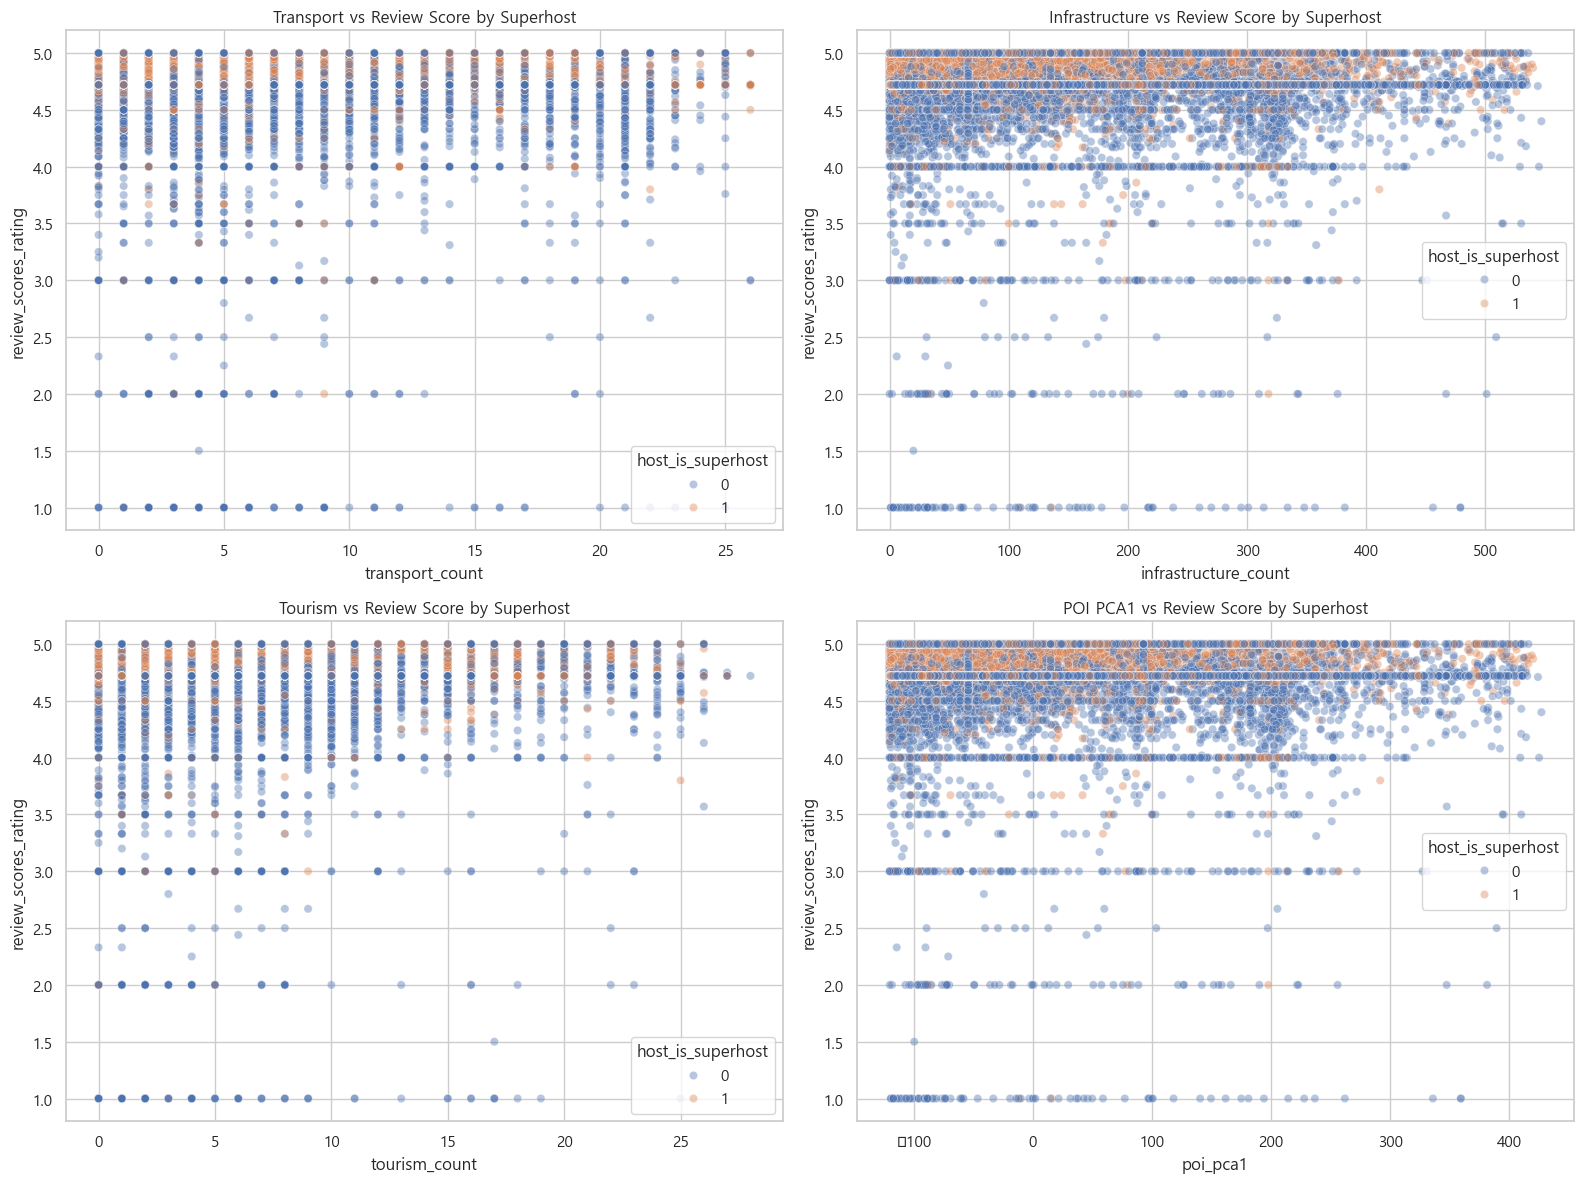

In [181]:
# 인프라가 조금 부족하더라도 서비스가 좋고 리뷰가 좋아서 슈퍼호스트가 되는 경우
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

plot_vars = [
    ('transport_count', 'Transport vs Review Score by Superhost'),
    ('infrastructure_count', 'Infrastructure vs Review Score by Superhost'),
    ('tourism_count', 'Tourism vs Review Score by Superhost'),
    ('poi_pca1', 'POI PCA1 vs Review Score by Superhost')
]

for i, (x_var, title) in enumerate(plot_vars):
    sns.scatterplot(
        data=df,
        x=x_var,
        y='review_scores_rating',
        hue='host_is_superhost',
        alpha=0.4,
        ax=axes[i]
    )
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [182]:
# price 정규성 검정
price_data = df['price'].dropna()

stat, p = stats.shapiro(price_data)

print(f"Shapiro-Wilk 통계량: {stat:.4f}") #실제 데이터가 정규분포에 얼마나 가까운지를 수치화한 값 (0~1 사이)
print(f"p-value: {p:.4f}")
if p > 0.05:
    print("정규성을 가정할 수 없다")
else:
    print("정규성을 가정할 수 없다")


Shapiro-Wilk 통계량: 0.2379
p-value: 0.0000
정규성을 가정할 수 없다


c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)


In [183]:
#로그변환 

log_price = np.log1p(df['price'].dropna())  # log(1 + price)로 0도 처리 가능
stat, p = stats.shapiro(log_price)

print(f"Shapiro-Wilk 통계량: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("로그 변환 후 정규성을 가정할 수 있다")
else:
    print("로그 변환 후에도 정규성을 가정할 수 없다")

Shapiro-Wilk 통계량: 0.9811
p-value: 0.0000
로그 변환 후에도 정규성을 가정할 수 없다


In [184]:
# price Mann-Whitney U 검정 
from scipy.stats import mannwhitneyu

group1 = df[df['host_is_superhost'] == 1]['price'].dropna()
group0 = df[df['host_is_superhost'] == 0]['price'].dropna()

stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
print(f"Mann-Whitney U 통계량: {stat:.4f}, p-value: {p:.4f}")

# 슈퍼호스트인지 아닌지 두그룹의 가격 분포에 차이가 있다

Mann-Whitney U 통계량: 45228149.5000, p-value: 0.0000


In [185]:
#수치형 변수/ 이진형/ 범주형 각각 t검정, 비모수검정, 카이제곱 검정 

from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency
import pingouin as pg   # 카이-제곱용

TARGET = 'host_is_superhost'

# 수치형 변수 리스트 (위도·경도·식별자 제외)
raw_num = [c for c in df.select_dtypes(include=['int64','float64']).columns
           if c not in ['latitude','longitude','host_id','id','host_is_superhost','Unnamed: 0']]

# 이진 수치형(0/1)만 골라내기
binary_num = [c for c in raw_num if df[c].dropna().isin([0,1]).all()]
continuous_num = [c for c in raw_num if c not in binary_num]

# 범주형 변수
cat_cols = df.select_dtypes(include=['object','category']).columns

results = []

# 연속형: 정규성 → t vs Mann-Whitney
def check_normality(series):
    return shapiro(series.dropna())[1] >= 0.05

for col in continuous_num:
    super = df[df[TARGET]==1][col].dropna()
    non   = df[df[TARGET]==0][col].dropna()
    
    if check_normality(super) and check_normality(non):
        stat, p = ttest_ind(super, non, equal_var=False)
        test = 't-test'
    else:
        stat, p = mannwhitneyu(super, non, alternative='two-sided')
        test = 'Mann-Whitney U'
    
    results.append({'variable':col, 'test':test, 'p':round(p,4)})

# 이진 수치형 & 범주형 → 카이제곱
for col in binary_num + cat_cols.tolist():
    ct = pd.crosstab(df[col], df[TARGET])
    chi2, p, _, _ = chi2_contingency(ct)
    results.append({'variable':col, 'test':'chi2', 'p':round(p,4)})

# 결과 정리
stat_df = pd.DataFrame(results).sort_values('p')
stat_df

c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6135.
  res = hypotest_fun_out(*samples, **kwds)


,variable,test,p
0,price,Mann-Whitney U,0.0000
1,estimated_occupancy_l365d,Mann-Whitney U,0.0000
2,estimated_revenue_l365d,Mann-Whitney U,0.0000
3,availability_60,Mann-Whitney U,0.0000
4,availability_365,Mann-Whitney U,0.0000
5,amenities_cnt,Mann-Whitney U,0.0000
9,number_of_reviews,Mann-Whitney U,0.0000
8,beds,Mann-Whitney U,0.0000
12,review_scores_rating,Mann-Whitney U,0.0000
13,review_scores_accuracy,Mann-Whitney U,0.0000


슈퍼호스트인지 아닌지는 accommodates(수용인원)과 host_identity_verified(호스트신원확인유무)와 관계없다 
귀무가설 기각하지 못함

In [186]:
#중앙값은 같음= 2
superhost_median = df[df['host_is_superhost'] == 1]['accommodates'].mean().round(2)
non_superhost_median = df[df['host_is_superhost'] == 0]['accommodates'].mean().round(2)

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

슈퍼호스트 중앙값: 2.86
일반 호스트 중앙값: 2.94


In [187]:
superhost_median = df[df['host_is_superhost'] == 1]['price'].median()
non_superhost_median = df[df['host_is_superhost'] == 0]['price'].median()

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

# 슈퍼호스트 중앙값이 더 낮다. 합리적인 가격이 슈퍼호스트가 되기에 유리하다값이 나옴 

슈퍼호스트 중앙값: 129.0
일반 호스트 중앙값: 147.0


In [188]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates']]

# 중앙값 테이블
median_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_median': [df[df['host_is_superhost'] == 1][col].median() for col in continuous_cols],
    'non_superhost_median': [df[df['host_is_superhost'] == 0][col].median() for col in continuous_cols]})

# 3) 확인
median_table.sort_values('superhost_median', ascending=False)

,variable,superhost_median,non_superhost_median
2,estimated_revenue_l365d,16830.000000,0.000000
4,availability_365,233.000000,270.000000
1,estimated_occupancy_l365d,166.000000,0.000000
0,price,129.000000,147.000000
23,infrastructure_count,63.000000,82.000000
5,amenities_cnt,37.000000,29.000000
3,availability_60,29.000000,53.000000
8,number_of_reviews,22.000000,2.000000
15,review_scores_communication,4.950000,4.810000
14,review_scores_checkin,4.940000,4.830000


In [189]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates']]

# 평균값 테이블 
avg_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_avg': [df[df['host_is_superhost'] == 1][col].mean().round(2) for col in continuous_cols],
    'non_superhost_avg': [df[df['host_is_superhost'] == 0][col].mean().round(2) for col in continuous_cols]})

# 3) 확인
avg_table.sort_values('superhost_avg', ascending=False)

,variable,superhost_avg,non_superhost_avg
2,estimated_revenue_l365d,23350.91,7558.93
4,availability_365,219.54,247.38
0,price,178.78,227.13
1,estimated_occupancy_l365d,141.79,44.92
23,infrastructure_count,100.54,127.65
8,number_of_reviews,55.23,26.43
5,amenities_cnt,36.41,28.51
3,availability_60,29.06,38.86
9,number_of_reviews_ltm,11.69,4.03
22,transport_count,5.15,6.37


In [190]:
# 숫자형 데이터 변수 
# 평균 + 중앙값 테이블 합치기
merged_table = pd.merge(
    avg_table,
    median_table,
    on='variable'
)

# 차이 컬럼 추가
merged_table['mean_diff'] = (merged_table['superhost_avg'] - merged_table['non_superhost_avg']).round(2)
merged_table['median_diff'] = (merged_table['superhost_median'] - merged_table['non_superhost_median']).round(2)

# 차이 기준 정렬 
merged_table.sort_values('mean_diff', ascending=False)

,variable,superhost_avg,non_superhost_avg,superhost_median,non_superhost_median,mean_diff,median_diff
2,estimated_revenue_l365d,23350.91,7558.93,16830.000000,0.000000,15791.98,16830.00
1,estimated_occupancy_l365d,141.79,44.92,166.000000,0.000000,96.87,166.00
8,number_of_reviews,55.23,26.43,22.000000,2.000000,28.80,20.00
5,amenities_cnt,36.41,28.51,37.000000,29.000000,7.90,8.00
9,number_of_reviews_ltm,11.69,4.03,3.000000,0.000000,7.66,3.00
20,host_acceptance_rate_score,3.73,3.43,4.000000,4.000000,0.30,0.00
10,number_of_reviews_l30d,0.53,0.24,0.000000,0.000000,0.29,0.00
19,host_response_rate_score,3.99,3.80,4.000000,4.000000,0.19,0.00
11,review_scores_rating,4.84,4.68,4.880000,4.720000,0.16,0.16
17,review_scores_value,4.73,4.57,4.780000,4.610000,0.16,0.17


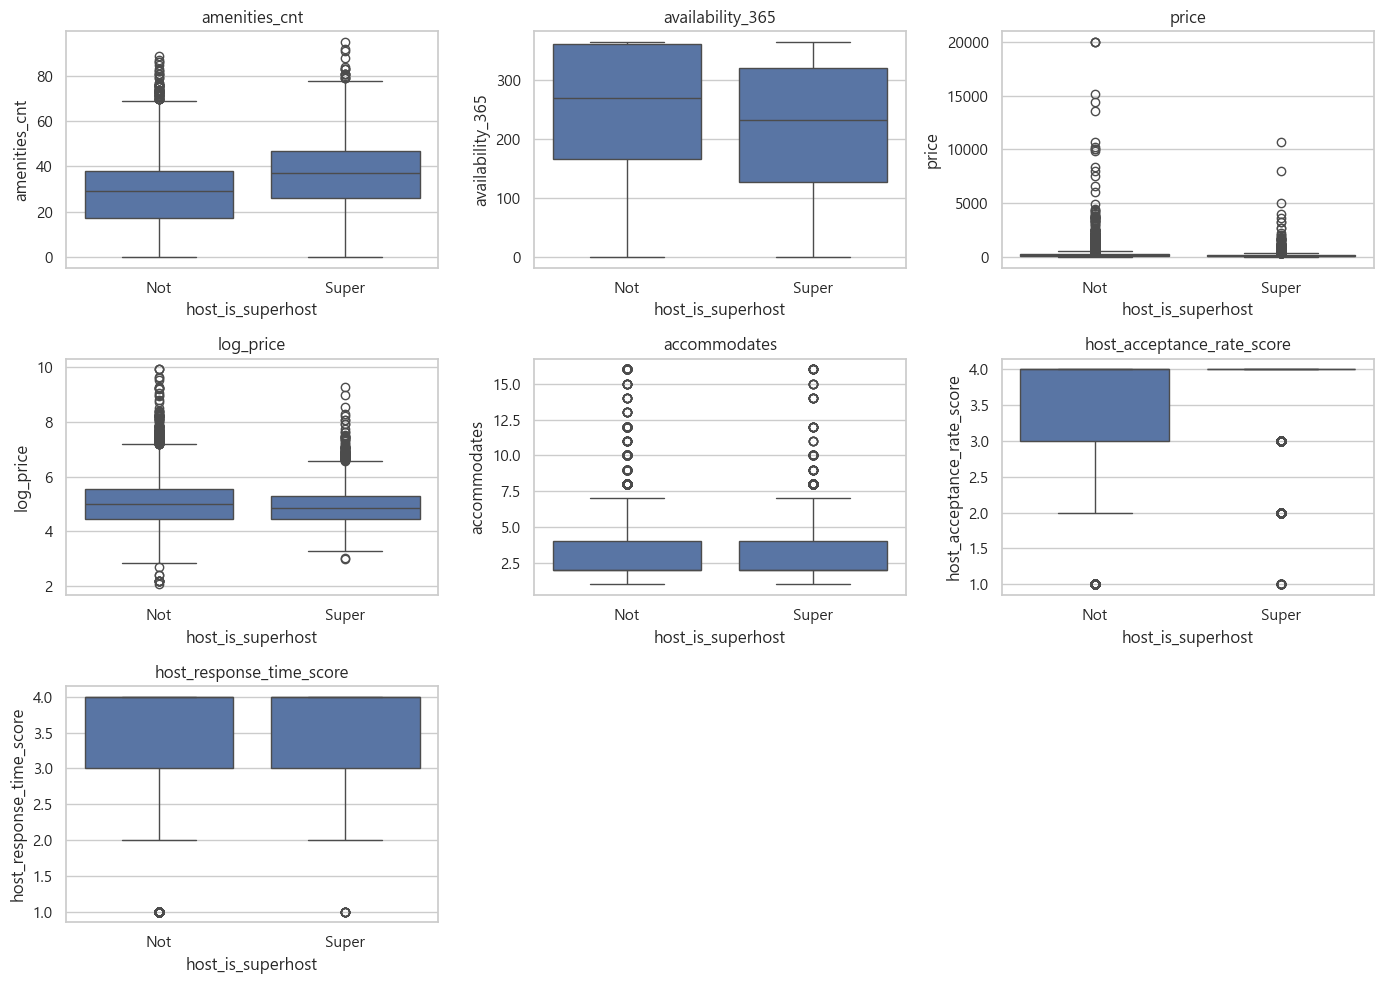

In [191]:
# 수치형 데이터(이진제외)시각화
import seaborn as sns
import matplotlib.pyplot as plt

continuous_cols = [
    'amenities_cnt', 'availability_365', 'price', 'log_price',
    'accommodates', 'host_acceptance_rate_score', 'host_response_time_score'
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='host_is_superhost', y=col, data=df)
    plt.title(col)
    plt.xticks([0, 1], ['Not', 'Super'])
plt.tight_layout()
plt.show()

In [192]:
# 이진수치형 데이터 변수
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 
# 비교 테이블 생성
bin_table = pd.DataFrame({'variable': bin_vars,
    'superhost_ratio(%)': [df[df['host_is_superhost'] == 1][col].mean().round(2) * 100 for col in bin_vars],
    'non_superhost_ratio(%)': [df[df['host_is_superhost'] == 0][col].mean().round(2) * 100 for col in bin_vars]})

# 차이 컬럼 추가
bin_table['ratio_diff(%)'] = (bin_table['superhost_ratio(%)'] - bin_table['non_superhost_ratio(%)']).round(2)

# 정렬 (차이 큰 순서)
bin_table = bin_table.sort_values('ratio_diff(%)', ascending=False)

# 확인
bin_table

# 변수가 1일때 슈퍼호스트와 비슈퍼호스트 비율
# is_activate 활성숙소가 슈퍼호스트는 87% 비슈퍼호스트는 62%
# 브루클린에 사는 호스트중 비 슈퍼호스트는 74% 슈퍼호스트는 80%
# 숙소주변 소개글이 있는 걸로 비율계산 해서 슈퍼호스트는 61% 비 슈퍼 호스트는 53%

,variable,superhost_ratio(%),non_superhost_ratio(%),ratio_diff(%)
5,is_activate,87.0,62.0,25.0
2,neighborhood_overview_exists,61.0,53.0,8.0
1,host_location_ny,74.0,66.0,8.0
0,host_location_boolean,81.0,75.0,6.0
6,host_has_profile_pic,99.0,96.0,3.0
4,instant_bookable,20.0,28.0,-8.0
3,is_long_term,71.0,84.0,-13.0


In [193]:
bin_table = pd.DataFrame({'variable': bin_vars,
    'superhost_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 for col in bin_vars],
    'superhost_0(%)': [(1-df[df['host_is_superhost']==1][col]).mean().round(2)*100 for col in bin_vars],
    'non_superhost_1(%)': [df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars],
    'non_superhost_0(%)': [(1-df[df['host_is_superhost']==0][col]).mean().round(2)*100 for col in bin_vars],
    'diff_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 -
                 df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars]})

bin_table = bin_table.sort_values('diff_1(%)', ascending=False)
bin_table

,variable,superhost_1(%),superhost_0(%),non_superhost_1(%),non_superhost_0(%),diff_1(%)
5,is_activate,87.0,13.0,62.0,38.0,25.0
2,neighborhood_overview_exists,61.0,39.0,53.0,47.0,8.0
1,host_location_ny,74.0,26.0,66.0,34.0,8.0
0,host_location_boolean,81.0,19.0,75.0,25.0,6.0
6,host_has_profile_pic,99.0,1.0,96.0,4.0,3.0
4,instant_bookable,20.0,80.0,28.0,72.0,-8.0
3,is_long_term,71.0,29.0,84.0,16.0,-13.0


In [194]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type,transport_count,infrastructure_count,tourism_count,poi_pca1
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,4,4,1,1,5.303305,mid,7,77,1,-43.212169
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,4,4,1,1,4.418841,upper-mid,3,79,4,-41.262176
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,4,2,1,1,6.641182,low-mid,11,109,2,-11.076188
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,4,4,1,1,4.941642,low-mid,4,34,2,-86.239807
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,4,4,1,1,4.875197,mid,7,117,1,-3.255546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,4,4,1,1,4.290459,mid,4,58,4,-62.204411
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,4,4,1,1,4.077537,mid,4,27,1,-93.262927
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,4,4,0,1,5.703782,mid,8,276,6,155.760579


범주형 데이터 - 
'neighbourhood_cleansed','neighbourhood_group_cleansed','structure_type','room_new_type','name_length_group','description_length_group','host_about_length_group' 

In [195]:
cat_var_room_new_type = 'room_new_type'
ct = pd.crosstab(df[cat_var_room_new_type], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_new_type,,
high,4.6,1.6
low-mid,12.6,17.8
mid,75.3,72.2
upper-mid,7.5,8.3


In [196]:
#범주형변수 룸타입 
cat_var_room = 'room_type'
ct = pd.crosstab(df[cat_var_room], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)
# 비슈퍼호스트일때와 슈퍼호스트일때 룸타입별 비율 

host_is_superhost,0,1
room_type,,
Entire home/apt,56.1,58.7
Hotel room,2.3,0.0
Private room,41.3,40.8
Shared room,0.4,0.5


In [197]:
cat_var_name = 'name_length_group'
ct = pd.crosstab(df[cat_var_name], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
name_length_group,,
long,47.8,53.2
short_or_med,52.2,46.8


In [198]:
cat_var_description = 'description_length_group'
ct = pd.crosstab(df[cat_var_description], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
description_length_group,,
empty,2.1,1.1
long,54.3,65.1
short_or_avg,43.6,33.8


In [199]:
cat_var_hostabout = 'host_about_length_group'
ct = pd.crosstab(df[cat_var_hostabout], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
host_about_length_group,,
empty,41.7,35.5
long,48.3,54.5
short_or_med,10.1,10.0


In [200]:
cat_var_structure = 'room_structure_type'
ct = pd.crosstab(df[cat_var_structure], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_structure_type,,
aparthotel,0.2,0.3
barn,0.0,0.0
bed and breakfast,0.3,0.3
boat,0.0,0.0
boutique hotel,1.2,0.2
bungalow,0.1,0.1
camper/rv,0.1,0.0
casa particular,0.2,0.2
condo,4.3,5.6


In [201]:
cat_var_neighbourhood = 'neighbourhood_cleansed'
ct = pd.crosstab(df[cat_var_neighbourhood], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_cleansed,,
Allerton,0.1,0.3
Arden Heights,0.0,0.0
Arrochar,0.0,0.0
Arverne,0.3,0.4
Astoria,1.2,1.7
...,...,...
Windsor Terrace,0.2,0.3
Woodhaven,0.3,0.4
Woodlawn,0.0,0.1


In [202]:
cat_var_group = 'neighbourhood_group_cleansed'
ct = pd.crosstab(df[cat_var_group], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_group_cleansed,,
Bronx,4.1,4.0
Brooklyn,31.3,38.9
Manhattan,48.8,37.6
Queens,14.4,17.8
Staten Island,1.3,1.8


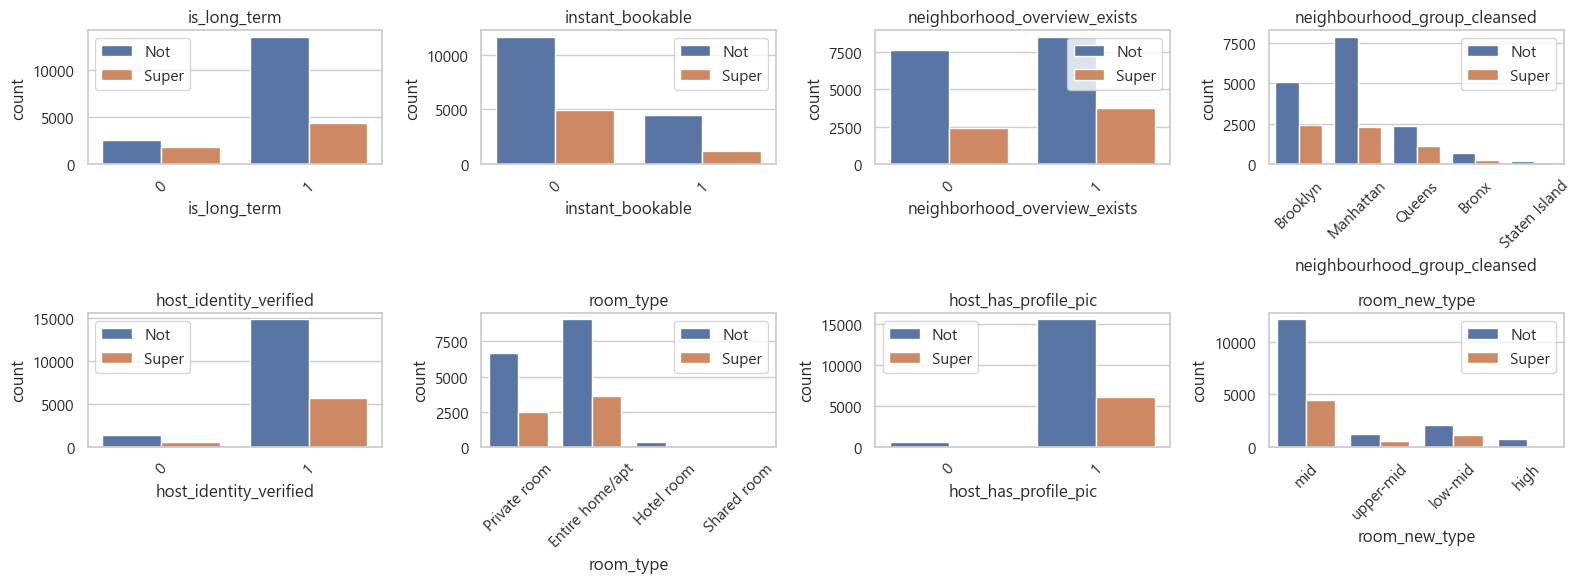

In [203]:
# 범주형/ 이진형 데이터 시각화 
cat_cols = [
    'is_long_term', 'instant_bookable', 'neighborhood_overview_exists',
    'neighbourhood_group_cleansed', 'host_identity_verified',
    'room_type', 'host_has_profile_pic', 'room_new_type']

n_cols = 4
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(16, 3 * n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=col, hue='host_is_superhost', data=df)
    plt.title(col)
    plt.legend(title=None, labels=['Not', 'Super'])
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [204]:
# 제외할 칼럼
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']

# 이진 수치형 변수 'host_identity_verified'귀무가설 기각 못해서 제외함
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 

# 전체 수치형 변수에서 이진 변수 제외
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]

# 범주형 변수
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 설정
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int) 

# 인코딩위해서 범주형과 숫자형(이진,숫자)으로 나누기 
cat_cols = [c for c in X.columns if X[c].dtype == 'object']   # 문자만
num_cols = [c for c in X.columns if X[c].dtype != 'object'] 

# 학습,테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [205]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 제외할 칼럼 및 이진 변수 지정
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']
bin_vars = ['host_location_boolean', 'host_location_ny',
            'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
            'is_activate', 'host_has_profile_pic']

# 수치형 / 범주형 변수 지정
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 분리
TARGET = 'host_is_superhost'
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------
# 1. ColumnTransformer 설정
# -----------------------

# 여기 sparse_output=True로 변경 (메모리 절약)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_vars),
    ('bin', 'passthrough', bin_vars)], remainder='drop', verbose_feature_names_out=False)
# .set_output(transform='pandas') →  제거 (sparse matrix와 pandas는 호환 안 됨)

# -----------------------
# 2. 사용할 모델들 정의
# -----------------------
models = {'Logistic': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'),}

# -----------------------
# 3. 모델 학습 및 평가
# -----------------------
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor),('classifier', clf)])

    # 학습
    pipe.fit(X_train, y_train)

    # 예측
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # 평가
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("AUC:", round(roc_auc_score(y_test, y_prob), 4))


=== Logistic ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3235
           1       0.60      0.75      0.66      1227

    accuracy                           0.79      4462
   macro avg       0.75      0.78      0.76      4462
weighted avg       0.81      0.79      0.80      4462

AUC: 0.8596

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3235
           1       0.82      0.63      0.71      1227

    accuracy                           0.86      4462
   macro avg       0.84      0.79      0.81      4462
weighted avg       0.86      0.86      0.85      4462

AUC: 0.9185


로지스틱 정확도 AUC : 79%  0.8582
랜덤포레스트 정확도 AUC : 86%  0.9165

F1-score는 로지스틱과 랜덤포레스트 모두 일반호스트예측이 높고 슈퍼호스트는 낮은편 그래도 랜덤포레스트가 두가지다 높은편

| 목적             | 사용 변수      | 모델링 목표                      |
| -------------- | ---------- | --------------------------- |
| **연관성 탐색 모델링** | 전체 변수(일부제외)   | “슈퍼호스트는 어떤 특성을 갖고 있을까?”     |
**전략 모델링**     | 전략가능 변수만 | “어떻게 하면 슈퍼호스트가 될 수 있을까?” |

In [206]:
# 연관성탐색 모델링부터 랜덤포레스트로 다시 
exclude_cols = ['host_is_superhost', 'amenities', 'host_id','longitude','latitude']
# 종속변수 제외한 전체 컬럼
cols = [c for c in df.columns if c not in exclude_cols ]
X = df[cols]
X = pd.get_dummies(X, drop_first=True)
y = df['host_is_superhost']
# 학습/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_train, y_train)

# 변수 중요도
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\n=== 변수 중요도 ===")
importances.sort_values(ascending=False).round(2)



=== 변수 중요도 ===


estimated_occupancy_l365d                 0.06
number_of_reviews_ltm                     0.05
estimated_revenue_l365d                   0.05
review_scores_rating                      0.04
amenities_cnt                             0.04
                                          ... 
neighbourhood_cleansed_Gerritsen Beach    0.00
neighbourhood_cleansed_Howland Hook       0.00
room_structure_type_tower                 0.00
neighbourhood_cleansed_Oakwood            0.00
room_structure_type_barn                  0.00
Length: 300, dtype: float64

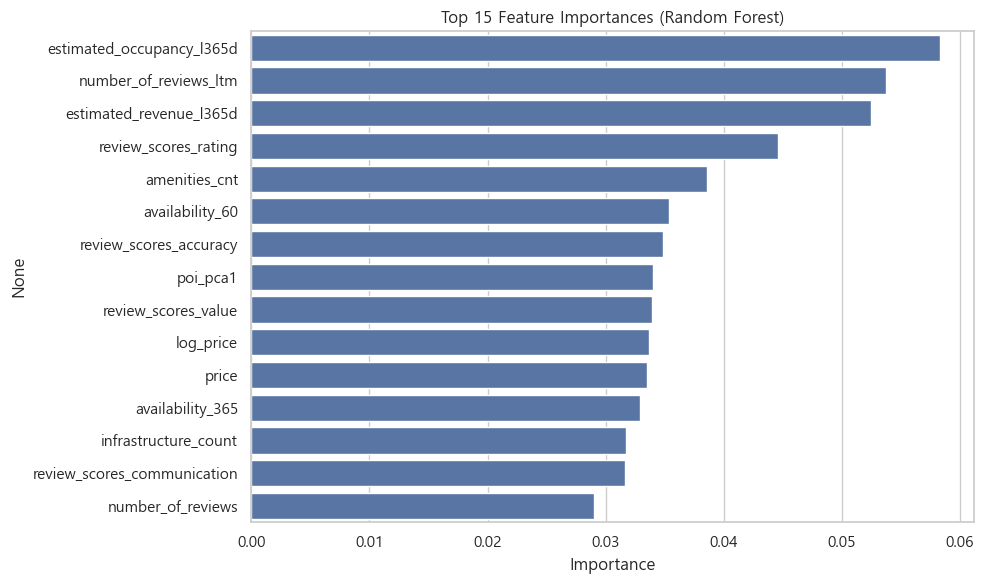

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [208]:
# 연관성탐색에서 변수중요도 기준으로 전략모델링 랜덤포레스트 
strategy_cols = ['amenities_cnt','availability_365','log_price','price','host_response_time_score','host_acceptance_rate_score','instant_bookable','host_about_length_group','room_type',
'neighbourhood_group_cleansed','host_has_profile_pic','neighborhood_overview_exists','name_length_group','description_length_group','is_long_term','accommodates','host_identity_verified','room_new_type']
# 중요 변수만 선택해서 전략 모델용 데이터셋 구성
X_top = df[strategy_cols]
X_top_encoded = pd.get_dummies(X_top)
# 학습/테스트 분할
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤포레스트로 학습 (전략 모델)
rf_top = RandomForestClassifier(n_estimators=300, random_state=42)
rf_top.fit(X_train_top, y_train_top)
# 평가 지표
y_pred_top = rf_top.predict(X_test_top)
y_proba_top = rf_top.predict_proba(X_test_top)[:, 1]

print("\n=== 전략 모델 성능 평가 (중요 변수만) ===")
print(classification_report(y_test_top, y_pred_top))
print("AUC:", roc_auc_score(y_test_top, y_proba_top))

# 변수 중요도
importances2 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances2.sort_values(ascending=False).round(2)


=== 전략 모델 성능 평가 (중요 변수만) ===
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3235
           1       0.77      0.52      0.62      1227

    accuracy                           0.83      4462
   macro avg       0.80      0.73      0.76      4462
weighted avg       0.82      0.83      0.81      4462

AUC: 0.8891841097208735

=== 변수 중요도 ===


amenities_cnt                                 0.16
availability_365                              0.14
price                                         0.12
log_price                                     0.12
accommodates                                  0.05
host_acceptance_rate_score                    0.05
host_response_time_score                      0.04
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
room_new_type_mid                             0.01
description_length_group_long                 0.01
description_length_group_short_or_avg         0.01
neighbourhood_group_cleansed_Queens           0.01
name_length_group_long                        0.01
room_type_Entire home/apt      

정확도 : 82%   Location넣어서 모델링하니까 정확도 88%까지 올라감 

AUC : 0.8874 0과 1사이에서 얼마나 잘 구분하는가 ->0.8891 조금 올라감 

recall/ f1-score 슈퍼호스트 잡는 비율이 낮음(재현율) 변화없음 

#그대로 진행 
정밀도 우선: 확신이 있을 때만 슈퍼호스트라고 인정 
슈퍼호스트라고 판단한 사람은 거의 진짜임 (정밀도 82)
하지만 ‘슈퍼호스트 맞는데 확신이 덜해서 못 뽑는 경우’가 많아짐 (재현율 52)

#임계점을 낮춤
재현율 우선: 조금만 “슈퍼호스트일 가능성 있다” 해도 다 슈퍼호스트라고 인정
많은 슈퍼호스트를 잘 찾아냄 (재현율 상승 52에서 83으로 상승함)
하지만 ‘사실은 슈퍼호스트 아닌 사람’도 많이 슈퍼호스트라고 뽑음 (정밀도하락 82에서 79로 하락)

전략인사이트 도출이 메인
변수 중요도가 중요하고, 임계값은 부차적인듯 
일단 정밀도 82와 재현율52(절반이상은 잡아냄)모델 
변수중요도에 있어서는 신뢰할 수준 인듯 


In [209]:
#임계점 낮춤 
threshold = 0.3
y_pred_new = (y_proba_top >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_top, y_pred_new))

# 변수 중요도
importances3 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances3.sort_values(ascending=False).round(2)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      3235
           1       0.60      0.84      0.70      1227

    accuracy                           0.80      4462
   macro avg       0.76      0.81      0.77      4462
weighted avg       0.84      0.80      0.81      4462


=== 변수 중요도 ===


amenities_cnt                                 0.16
availability_365                              0.14
price                                         0.12
log_price                                     0.12
accommodates                                  0.05
host_acceptance_rate_score                    0.05
host_response_time_score                      0.04
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
room_new_type_mid                             0.01
description_length_group_long                 0.01
description_length_group_short_or_avg         0.01
neighbourhood_group_cleansed_Queens           0.01
name_length_group_long                        0.01
room_type_Entire home/apt      

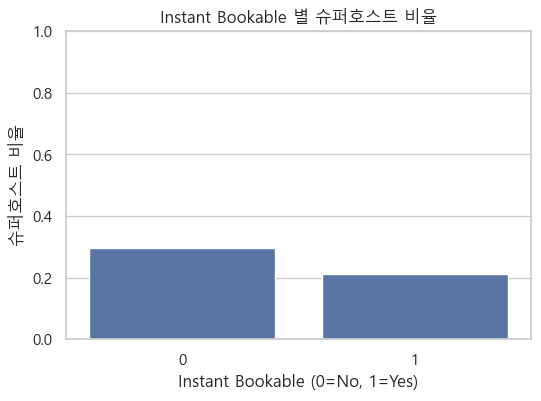

In [211]:
plt.rcParams['font.family'] = 'Malgun Gothic'

# instant_bookable 별 슈퍼호스트 비율 계산
rate_instant = df.groupby('instant_bookable')['host_is_superhost'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='instant_bookable', y='host_is_superhost', data=rate_instant)
plt.xlabel('Instant Bookable (0=No, 1=Yes)')
plt.ylabel('슈퍼호스트 비율')
plt.title('Instant Bookable 별 슈퍼호스트 비율')
plt.ylim(0, 1)
plt.show()

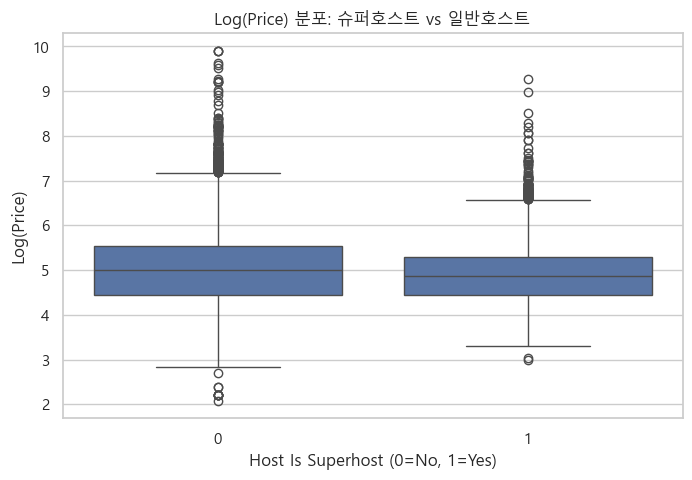

In [212]:
plt.figure(figsize=(8,5))
sns.boxplot(x='host_is_superhost', y='log_price', data=df)
plt.xlabel('Host Is Superhost (0=No, 1=Yes)')
plt.ylabel('Log(Price)')
plt.title('Log(Price) 분포: 슈퍼호스트 vs 일반호스트')
plt.show()

In [215]:
df['amenities']

id
36121                  ['Refrigerator', 'Dishes and silverware', 'Wif...
36647                  ['Oven', 'Blender', 'Luggage dropoff allowed',...
38663                  ['Portable fans', 'Oven', 'Baking sheet', 'Fir...
38833                  ['Fire extinguisher', 'Clothing storage: close...
39282                  ['Oven', 'Rice maker', 'Laundromat nearby', 'L...
                                             ...                        
1366333532374850165    ['Air conditioning', 'Carbon monoxide alarm', ...
1366717321390111215    ['Air conditioning', 'Carbon monoxide alarm', ...
1366721904709517353    ['Air conditioning', 'Carbon monoxide alarm', ...
1366722692755341871    ['Oven', 'Gym', 'Blender', 'Dedicated workspac...
1366723228243064949    ['Air conditioning', 'Carbon monoxide alarm', ...
Name: amenities, Length: 22308, dtype: object

room_new_type

공통 amenity (필수):
['Carbon monoxide alarm', 'Essentials', 'Hangers', 'Smoke alarm', 'Wifi']

high 특화 amenity:
['Air conditioning', 'Building staff', 'Elevator', 'Gym', 'Heating', 'Paid parking off premises', 'Shampoo']

low-mid 특화 amenity:
['Cleaning products', 'Dining table', 'Exterior security cameras on property', 'Free street parking', 'Freezer', 'Laundromat nearby', 'Lock on bedroom door', 'Microwave']

mid 특화 amenity:
['Cooking basics', 'Kitchen', 'Oven']

upper-mid 특화 amenity:
['Bathtub', 'Cleaning products', 'Cooking basics', 'Dishes and silverware', 'Elevator', 'Freezer']

In [220]:
import pandas as pd
import ast

# 기준 Amenity 딕셔너리 정의
common_amenities = ['Carbon monoxide alarm', 'Essentials', 'Hangers', 'Smoke alarm', 'Wifi']

type_amenity_dict = {
    'high': ['Air conditioning', 'Building staff', 'Elevator', 'Gym', 'Heating', 'Paid parking off premises', 'Shampoo'],
    'low-mid': ['Cleaning products', 'Dining table', 'Exterior security cameras on property', 'Free street parking', 
                'Freezer', 'Laundromat nearby', 'Lock on bedroom door', 'Microwave'],
    'mid': ['Cooking basics', 'Kitchen', 'Oven'],
    'upper-mid': ['Bathtub', 'Cleaning products', 'Cooking basics', 'Dishes and silverware', 'Elevator', 'Freezer']}

# amenities 문자열 → 리스트로 파싱
def parse_amenities(row):
    try:
        return ast.literal_eval(row)
    except:
        return []

df['parsed_amenities'] = df['amenities'].apply(parse_amenities)

# amenity 매칭 점수 계산 함수
def calc_match_score(row):
    amenities = row['parsed_amenities']
    room_type = row['room_new_type']  # ← 미리 이 컬럼 만들어져 있어야 함
    
    # 공통 어매니티 일치 비율
    common_match = sum(1 for a in amenities if a in common_amenities) / len(common_amenities)
    
    # room type 별 특화 어매니티 일치 비율
    type_amenities = type_amenity_dict.get(room_type, [])
    if type_amenities:
        type_match = sum(1 for a in amenities if a in type_amenities) / len(type_amenities)
    else:
        type_match = 0.0
    
    return pd.Series({
        'common_amenity_score': round(common_match, 3),
        'type_amenity_score': round(type_match, 3)})

# 점수 컬럼 추가
df[['common_amenity_score', 'type_amenity_score']] = df.apply(calc_match_score, axis=1)

# 점수 해석을 위한 요약 출력
print(df[['room_new_type', 'common_amenity_score', 'type_amenity_score']].groupby('room_new_type').mean().round(3))



               common_amenity_score  type_amenity_score
room_new_type                                          
high                          0.882               0.673
low-mid                       0.842               0.501
mid                           0.838               0.673
upper-mid                     0.883               0.523


In [234]:
df[['common_amenity_score','type_amenity_score','room_type','room_new_type','amenities']]

,common_amenity_score,type_amenity_score,room_type,room_new_type,amenities
id,,,,,
36121,0.2,0.333,Private room,mid,"['Refrigerator', 'Dishes and silverware', 'Wif..."
36647,0.6,0.833,Private room,upper-mid,"['Oven', 'Blender', 'Luggage dropoff allowed',..."
38663,0.8,0.625,Private room,low-mid,"['Portable fans', 'Oven', 'Baking sheet', 'Fir..."
38833,1.0,0.625,Entire home/apt,low-mid,"['Fire extinguisher', 'Clothing storage: close..."
39282,0.6,1.000,Private room,mid,"['Oven', 'Rice maker', 'Laundromat nearby', 'L..."
...,...,...,...,...,...
1366333532374850165,0.6,0.333,Private room,mid,"['Air conditioning', 'Carbon monoxide alarm', ..."
1366717321390111215,0.6,0.333,Private room,mid,"['Air conditioning', 'Carbon monoxide alarm', ..."
1366721904709517353,0.6,0.333,Entire home/apt,mid,"['Air conditioning', 'Carbon monoxide alarm', ..."


In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# 전략 점수 2개를 포함한 전략 변수 리스트
strategy_cols = [
    'amenities_cnt','availability_365','price','host_response_time_score',
    'host_acceptance_rate_score','instant_bookable','host_about_length_group','room_type',
    'neighbourhood_group_cleansed','host_has_profile_pic','neighborhood_overview_exists',
    'name_length_group','description_length_group','is_long_term','accommodates',
    'host_identity_verified','room_new_type','common_amenity_score', 'type_amenity_score']

# 설명 변수: 원핫 인코딩 포함
X_top = df[strategy_cols]
X_top_encoded = pd.get_dummies(X_top, drop_first=True)

# 목표 변수
y = df['host_is_superhost']

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_top_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 개별 모델 정의
log_reg = LogisticRegression(max_iter=3000, random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42)

# 소프트 보팅 앙상블
ensemble = VotingClassifier(estimators=[('lr', log_reg), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

# 예측 및 평가
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

print("\n=== 소프트 보팅 앙상블 평가 결과 ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# 로지스틱 회귀 계수 분석
log_reg.fit(X_train, y_train)
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]}).sort_values(by='Coefficient', ascending=False)

print("\n=== 로지스틱 회귀 계수 상위 변수 ===")
print(coeff_df.round(3).head(10))

print("\n=== 로지스틱 회귀 계수 하위 변수 ===")
print(coeff_df.round(3).tail(10))


c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== 소프트 보팅 앙상블 평가 결과 ===
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      3235
           1       0.77      0.41      0.53      1227

    accuracy                           0.80      4462
   macro avg       0.79      0.68      0.71      4462
weighted avg       0.80      0.80      0.78      4462

AUC: 0.8659874614073606

=== 로지스틱 회귀 계수 상위 변수 ===
                                       Feature  Coefficient
6                         host_has_profile_pic        0.775
11                        common_amenity_score        0.517
4                   host_acceptance_rate_score        0.425
23               description_length_group_long        0.402
25                       room_new_type_low-mid        0.392
18       neighbourhood_group_cleansed_Brooklyn        0.313
21  neighbourhood_group_cleansed_Staten Island        0.277
20         neighbourhood_group_cleansed_Queens        0.238
13                host_about_length_group_long        0.2

c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


상위 영향력 변수 (긍정적인 영향 → 슈퍼호스트일 가능성 ↑)

| 순위 | 변수명                                      | 계수         | 해석                        |
| -- | ---------------------------------------- | ---------- | ------------------------- |
| 1  | `host_has_profile_pic`                   | **+0.825** | 프로필 사진이 있는 경우 슈퍼호스트 가능성 ↑ |
| 2  | `common_amenity_score`                   | **+0.448** | 공통 어매니티 보유 비율 높을수록 유리     |
| 3  | `host_acceptance_rate_score`             | +0.396     | 수락률이 높을수록 슈퍼호스트 가능성 ↑     |
| 4  | `neighbourhood_group_cleansed_Brooklyn`  | +0.375     | 브루클린 지역이 비교적 유리           |
| 5  | `room_new_type_low-mid`                  | +0.335     | low-mid급 숙소가 중간 이상 선호됨    |
| 6  | `neighbourhood_group_cleansed_Manhattan` | +0.236     | 맨해튼도 긍정적 영향               |
| 7  | `host_about_length_group_long`           | +0.223     | 호스트 소개글 길수록 신뢰도 ↑         |
| 8  | `neighbourhood_group_cleansed_Queens`    | +0.211     | 퀸즈 지역도 긍정적 영향             |
| 9  | `description_length_group_long`          | +0.205     | 숙소 설명이 길면 긍정적             |
| 10 | `room_new_type_upper-mid`                | +0.176     | upper-mid 숙소 유형도 긍정적      |

하위 영향력 변수 (부정적인 영향 → 슈퍼호스트 확률 ↓)

| 변수                       | 계수         | 해석                      |
| ------------------------ | ---------- | ----------------------- |
| `room_type_Hotel room`   | **-1.513** | 호텔형 숙소는 슈퍼호스트 되기 어려움    |
| `is_long_term`           | -1.009     | 장기 운영 위주인 경우 불리함        |
| `log_price`              | -0.747     | 가격이 높을수록 슈퍼호스트 확률 ↓     |
| `room_type_Private room` | -0.654     | 개인실은 불리한 편              |
| `instant_bookable`       | -0.557     | 즉시 예약 가능 여부가 오히려 부정적 영향 |

랜덤포레스트중요도/ 로지스틱계수 (중요 변수별 전략 요약)

| 순위 | 변수                                   | 중요도 계수         | 슈퍼호스트 vs 비슈퍼 평균 차     | 추천 행동                    |
| -- | ------------------------------------ | -------------- | --------------------- | ------------------------ |
| 1  | `amenities_cnt`                      | 0.17 (RF 기준)   | 슈퍼호스트 평균 +8개          | 필수 공통 어매니티 **37개 이상 등록** |
| 2  | `availability_365`                   | 0.15           | 평균 -27일               | 실제 운영 가능한 날짜만 열기         |
| 3  | `log_price`                          | -0.747         | 평균 -0.13 log / 약 \$48 | 가격은 지역 평균 ±10%           |
| 4  | `host_acceptance_rate_score`         | 0.396          | +0.3                  | 가능한 모든 예약 수락             |
| 5  | `host_response_time_score`           | 0.14           | +0.14                 | 1시간 이내 자동 응답 메시지 세팅      |
| 6  | `is_long_term`                       | -1.009         | 비슈퍼 쪽이 장기 더 많음        | **단기 운영 중심 전략** 필요       |
| 7  | `instant_bookable`                   | -0.557         | 슈퍼호스트 20%만 사용         | **즉시예약 OFF 유지**          |
| 8  | `description_length_group_long`      | +0.205         | 슈퍼호스트 +65%            | 구조·편의시설 상세 기재            |
| 9  | `host_about_length_group_long`       | +0.223         | 장문 비율 +54%            | 소개글 100자 이상              |
| 10 | `neighborhood_overview_exists`       | 0.02           | 슈퍼호스트 61%             | 동네 소개 필수                 |
| 11 | `host_has_profile_pic`               | 0.825          | 슈퍼호스트 99%             | 밝고 정면 프로필 사진 필수          |
| 12 | `room_new_type_low-mid`, `upper-mid` | +0.33 \~ +0.17 | mid/low-mid 선호        | 시설 잘 갖춘 중간가격 숙소 유지       |


In [ ]:
def preprocess_input(new_data_df, train_columns):
    """
    신규 데이터 전처리 함수
    - 원핫인코딩 적용
    - 훈련 데이터 컬럼과 일치하도록 맞춤
    """
    # 원핫인코딩 (drop_first=True 적용한 훈련과 동일하게)
    new_data_encoded = pd.get_dummies(new_data_df, drop_first=True)
    
    # 훈련 데이터 컬럼과 맞추기 (없는 컬럼은 0으로 채움)
    missing_cols = set(train_columns) - set(new_data_encoded.columns)
    for c in missing_cols:
        new_data_encoded[c] = 0
    
    # 순서 맞추기
    new_data_encoded = new_data_encoded[train_columns]
    
    return new_data_encoded

def predict_superhost(new_data_df, model, train_columns):
    """
    신규 데이터 받아서 슈퍼호스트 여부 예측
    """
    # 전처리
    X_new = preprocess_input(new_data_df, train_columns)
    
    # 예측 (확률)
    proba = model.predict_proba(X_new)[:,1]
    pred = model.predict(X_new)
    
    # 결과 반환 (DataFrame 형태로 예: 확률과 예측결과 같이 반환)
    result = new_data_df.copy()
    result['superhost_probability'] = proba
    result['superhost_prediction'] = pred
    
    return result

In [238]:
new_data_df = pd.DataFrame([{
    'amenities_cnt': 15,
    'availability_365': 300,
    'price': 90,
    'host_response_time_score': 0.8,
    'host_acceptance_rate_score': 0.9,
    'instant_bookable': 1,
    'host_about_length_group': 'long',            # ['short', 'med', 'long']
    'room_type': 'Entire home/apt',               # ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']
    'neighbourhood_group_cleansed': 'Manhattan',  # ['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island']
    'host_has_profile_pic': 1,
    'neighborhood_overview_exists': 1,
    'name_length_group': 'long',                  # ['short', 'short_or_med', 'long']
    'description_length_group': 'long',           # ['short_or_avg', 'long']
    'is_long_term': 0,
    'accommodates': 3,
    'host_identity_verified': 1,
    'room_new_type': 'mid',                       # ['low', 'low-mid', 'mid', 'high']
    'common_amenity_score': 0.67,
    'type_amenity_score': 0.44
}])

# 예측 실행
result_df = predict_superhost(new_data_df, model=ensemble, train_columns=X_train.columns)

# 결과 보기
print(result_df[['superhost_probability', 'superhost_prediction']])

   superhost_probability  superhost_prediction
0               0.071214                     0
